In [1]:
import scanpy as sc
import scanpy.external as sce
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import silhouette_score
from collections import deque
import anndata
from scipy.stats import fisher_exact

In [2]:
# def cal_clust_silhouette(adata, n_pcs, resolution):
#     tmp_adata = sc.pp.neighbors(adata, n_pcs=n_pcs, copy=True)
#     sc.tl.umap(tmp_adata)
#     sc.tl.leiden(tmp_adata, key_added="leiden_res", resolution=resolution)
#     return silhouette_score(tmp_adata.X, tmp_adata.obs['leiden_res'])

# Preprocess

## read data

In [2]:
cxtri_path = '/public21/home/sc90258/huangying/analysis/12.pan_mosquito/20250318_replot_mosq/cxtri/1.QC.h5ad'
cxtri_bl_path = '/public21/home/sc90258/huangying/analysis/12.pan_mosquito/20250318_replot_mosq/cxtri-bl/1.QC.h5ad'

In [3]:
cxtri = sc.read(cxtri_path)
cxtri.obs_names = [f'{i}-cxtri' for i in cxtri.obs_names]
cxtri_bl = sc.read(cxtri_bl_path)
cxtri_bl.obs_names = [f'{i}-bl' for i in cxtri_bl.obs_names]

## concat AnnData

In [4]:
adata = anndata.concat([cxtri, cxtri_bl], join="inner", label="batch", keys=['cxtri', 'cxtri-bl'])
adata
# adata = rep1.concatenate(rep2, batch_categories=["rep1", "rep2"])
# adata

AnnData object with n_obs × n_vars = 10083 × 12802
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier', 'batch'

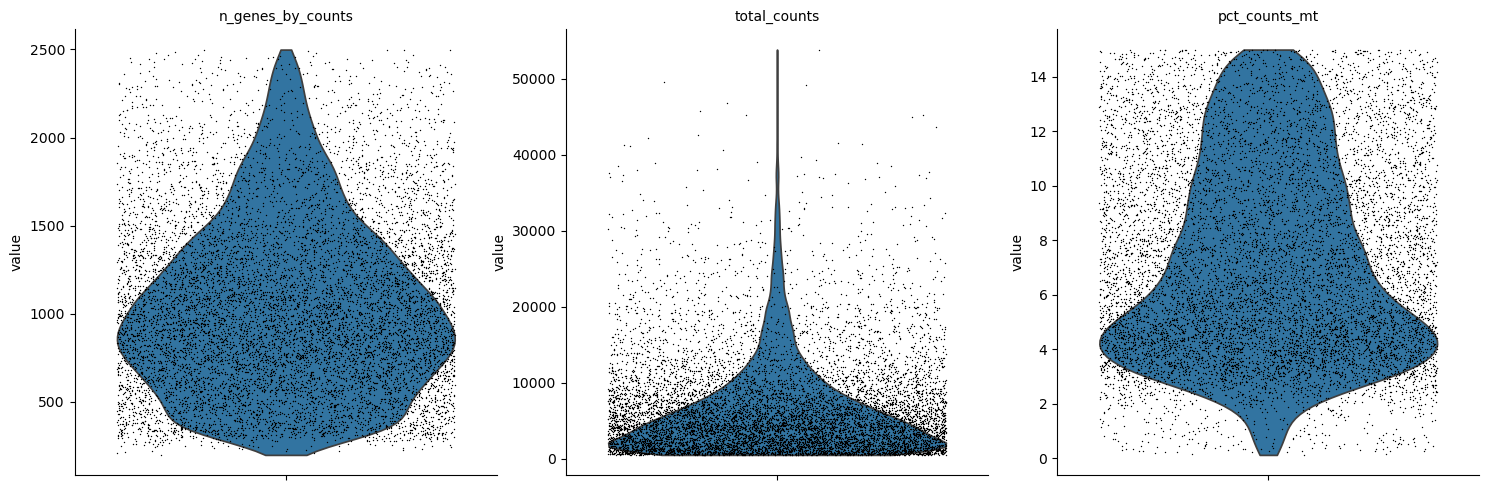

In [5]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

## normalization and peak find variable genes

In [6]:
# normalization 
sc.pp.normalize_total(
    adata, 
    target_sum=1e6, 
    exclude_highly_expressed=True
)
# Logarithmize
sc.pp.log1p(adata)
# find highly variable genes
sc.pp.highly_variable_genes(
    adata, n_top_genes=4000, flavor='seurat_v3')
# save original AnnData to `.raw` attribute
adata.raw = adata
# only keeping highly variable genes in AnnData
adata = adata[:, adata.var.highly_variable]
# scale each gene to unit variance
sc.pp.scale(adata)

adata

/public21/home/sc90258/miniconda3/envs/hy-scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:73: UserWarning: `flavor='seurat_v3'` expects raw count data, but non-integers were found.
  warnings.warn(
/public21/home/sc90258/miniconda3/envs/hy-scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_scale.py:317: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


AnnData object with n_obs × n_vars = 10083 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier', 'batch'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'log1p', 'hvg'

In [7]:
# save data
adata.write("1.before_integrate.h5ad")

# Intergrate data by Harmonoy

In [8]:
# read in data
adata = sc.read('./1.before_integrate.h5ad')
adata

AnnData object with n_obs × n_vars = 10083 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier', 'batch'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'

In [9]:
# run PCA
sc.pp.pca(adata, svd_solver="auto", use_highly_variable=True)
# run harmonoy
sce.pp.harmony_integrate(adata, 'batch')

/public21/home/sc90258/miniconda3/envs/hy-scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_pca/__init__.py:438: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)
2025-04-08 11:25:32,822 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-04-08 11:25:37,004 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-04-08 11:25:37,116 - harmonypy - INFO - Iteration 1 of 10
2025-04-08 11:25:41,812 - harmonypy - INFO - Iteration 2 of 10
2025-04-08 11:25:46,463 - harmonypy - INFO - Iteration 3 of 10
2025-04-08 11:25:51,088 - harmonypy - INFO - Iteration 4 of 10
2025-04-08 11:25:56,318 - harmonypy - INFO - Iteration 5 of 10
2025-04-08 11:26:00,874 - harmonypy - INFO - Iteration 6 of 10
2025-04-08 11:26:05,847 - harmonypy - INFO - Converged after 

In [10]:
adata.obsm['X_pca_raw'] = adata.obsm['X_pca']
adata.obsm['X_pca'] = adata.obsm['X_pca_harmony']

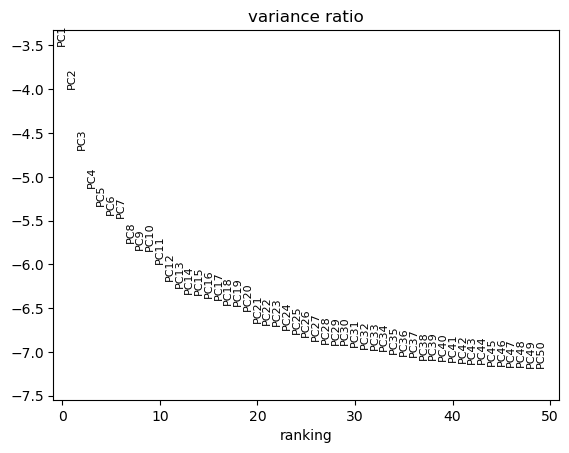

In [11]:
# plot single PCs to the total variance in the data
sc.pl.pca_variance_ratio(adata, n_pcs=50, log=True)

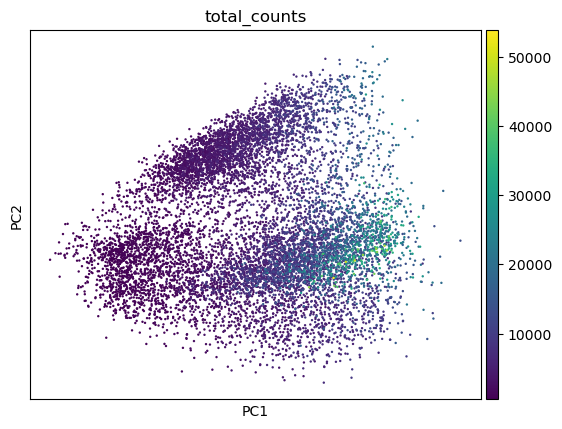

In [12]:
sc.pl.pca_scatter(adata, color="total_counts")

In [13]:
# save data
adata.write("2.integrated.h5ad")
# show Anndata
adata

AnnData object with n_obs × n_vars = 10083 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier', 'batch'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_raw'
    varm: 'PCs'

# clustering

In [14]:
adata = sc.read("2.integrated.h5ad")
adata

AnnData object with n_obs × n_vars = 10083 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier', 'batch'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_raw'
    varm: 'PCs'

## plot UMAP

/public21/home/sc90258/miniconda3/envs/hy-scanpy/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/tmp/ipykernel_168067/117608690.py:6: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(


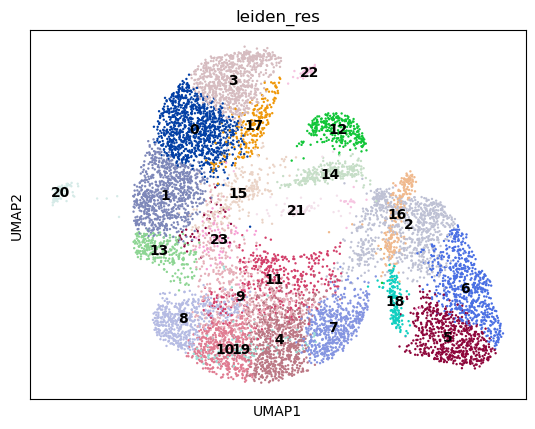

In [15]:
adata = sc.pp.neighbors(adata, n_neighbors=100, n_pcs=30, copy=True)
sc.tl.umap(
    adata, 
    min_dist=0.5,
)
sc.tl.leiden(
    adata, 
    key_added="leiden_res", 
    resolution=1.8,
)

sc.pl.umap(
    adata,
    color=["leiden_res"],
    legend_loc="on data",
)

In [16]:
adata.obs['leiden_res'].value_counts()

leiden_res
0     1037
1      823
2      818
3      811
4      753
5      648
6      636
7      558
8      534
9      507
10     502
11     387
12     286
13     267
14     262
15     235
16     232
17     222
18     166
19     107
20      94
21      72
22      66
23      60
Name: count, dtype: int64

In [17]:
# save data
adata.write("3.cluster.h5ad")
# show AnnData
adata

AnnData object with n_obs × n_vars = 10083 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier', 'batch', 'leiden_res'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca', 'neighbors', 'umap', 'leiden_res', 'leiden_res_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_raw', 'X_umap'
    varm: 'PCs'
    obsp: 'distances', 'connectivities'

# Annotation

In [2]:
# read in data
adata = sc.read('./3.cluster.h5ad')
adata

AnnData object with n_obs × n_vars = 10083 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier', 'batch', 'leiden_res'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'leiden_res', 'leiden_res_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_raw', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

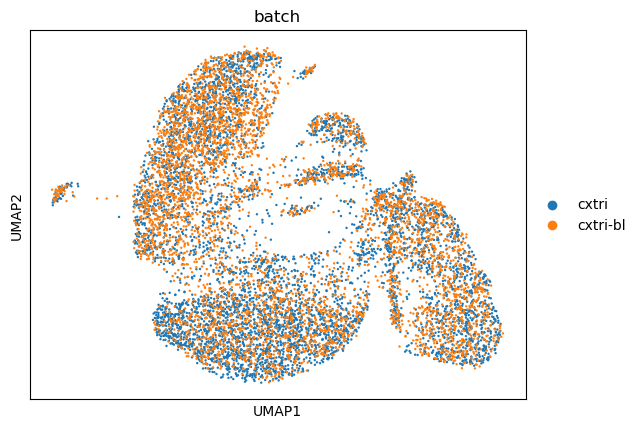

In [19]:
sc.pl.umap(
    adata,
    color=["batch"],
)

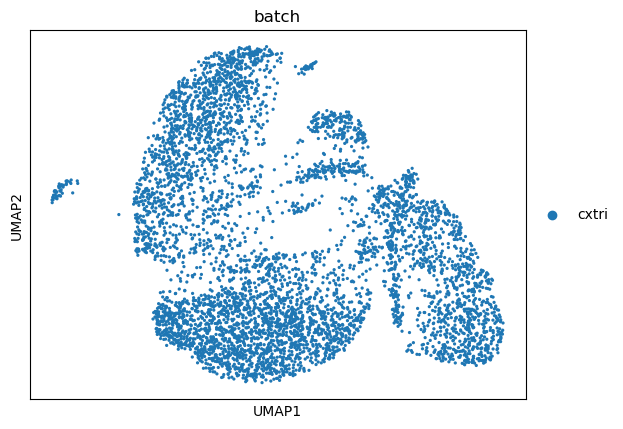

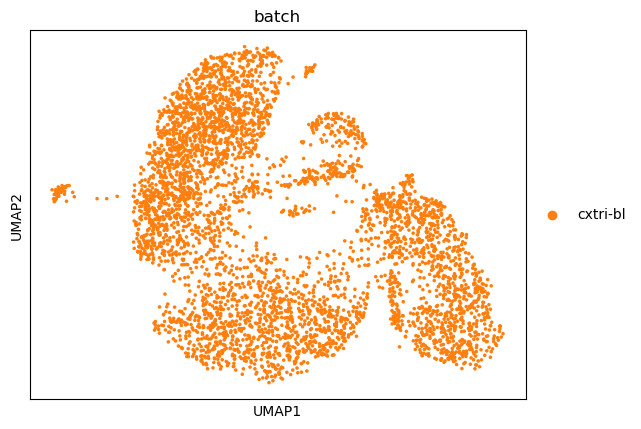

In [20]:
for i in ['cxtri', 'cxtri-bl']:
    sc.pl.umap(adata[adata.obs['batch'] == i], color=["batch"])

In [3]:
aae_homo = pd.read_csv('/public21/home/sc90258/huangying/analysis/12.pan_mosquito/20240830_homo_gene/cxtri_aae.homog.csv')
aae_homo

,cxtri,aae
0,Ctri05375,LOC110673977
1,Ctri05761,LOC110673980
2,Ctri12482,LOC110673981
3,Ctri03408,LOC110673983
4,Ctri02287,LOC110673984
...,...,...
9152,Ctri05472,LOC5580326
9153,Ctri05473,LOC5580327
9154,Ctri05470,LOC5580329
9155,Ctri05866,LOC5580330


In [4]:
# 'Ctri08281': 'fibulin-1'
marker_genes_raw = {
    'ISC/EB': ['LOC5563695', 'LOC5578162', 'LOC5580156', 'LOC5570443', 'LOC5580247'], # Klu, Delta, esg, LYSC11, PCNA , 'LOC110676293', 'LOC5580247'
    'Cardia': ['LOC5564993', 'LOC5572257'], # GAM1, LYZ1 ['LOC5568253', 'LOC5572257'] FCN3, CTRB2 'LOC5579458', 
    'EC': ['LOC23687865', 'LOC5573855'], # Nub, CPA-VII 'LOC5573855', 
    'EC-like': ['LOC5574806', 'LOC5570613'], # CAH7, Cht10, SNAT1, LYZL 'LOC5571803', 
    'EE': ['LOC5575988', 'LOC5569132', 'LOC5575886', 'LOC5573874'], # prospero, orcokinin, npf, Calexcitin-1
    'VM':['LOC5571832'], # actin
    # 'FBC':['LOC5571084'], # apolipophorin-3
    'HC':['LOC5570883', 'LOC110674010'], # LRIM16, NimB2
}

In [5]:
mg_homo = []
for k, v in marker_genes_raw.items():
    print(f'{k}:')
    for g in v:
        res = aae_homo[aae_homo['aae'] == g]
        if res.empty:
            print(f'{g}: NA')
        else:
            print(res)
            mg_homo.append(res)
mg_homo = pd.concat(mg_homo, axis=0)
mg_homo = dict(mg_homo.iloc[:, [1,0]].values)
mg_homo

ISC/EB:
         cxtri         aae
979  Ctri08281  LOC5563695
          cxtri         aae
8290  Ctri05145  LOC5578162
          cxtri         aae
9066  Ctri06068  LOC5580156
          cxtri         aae
4373  Ctri04136  LOC5570443
          cxtri         aae
9117  Ctri05970  LOC5580247
Cardia:
LOC5564993: NA
          cxtri         aae
5308  Ctri06126  LOC5572257
EC:
         cxtri          aae
872  Ctri03519  LOC23687865
LOC5573855: NA
EC-like:
          cxtri         aae
6660  Ctri09069  LOC5574806
          cxtri         aae
4454  Ctri01811  LOC5570613
EE:
          cxtri         aae
7233  Ctri01973  LOC5575988
LOC5569132: NA
LOC5575886: NA
          cxtri         aae
6162  Ctri02594  LOC5573874
VM:
          cxtri         aae
5090  Ctri09277  LOC5571832
HC:
LOC5570883: NA
        cxtri           aae
21  Ctri04212  LOC110674010


{'LOC5563695': 'Ctri08281',
 'LOC5578162': 'Ctri05145',
 'LOC5580156': 'Ctri06068',
 'LOC5570443': 'Ctri04136',
 'LOC5580247': 'Ctri05970',
 'LOC5572257': 'Ctri06126',
 'LOC23687865': 'Ctri03519',
 'LOC5574806': 'Ctri09069',
 'LOC5570613': 'Ctri01811',
 'LOC5575988': 'Ctri01973',
 'LOC5573874': 'Ctri02594',
 'LOC5571832': 'Ctri09277',
 'LOC110674010': 'Ctri04212'}

In [6]:
marker_genes = {}
for k, v in marker_genes_raw.items():
    marker_genes[k] = [mg_homo[i] for i in v if i in mg_homo.keys()]

marker_genes['EC-like'] = ['Ctri09069', 'Ctri09956', 'Ctri09123', 'Ctri01811']
marker_genes['EE'] += ['Ctri04723', 'Ctri05940', 'Ctri07102']

marker_genes

{'ISC/EB': ['Ctri08281', 'Ctri05145', 'Ctri06068', 'Ctri04136', 'Ctri05970'],
 'Cardia': ['Ctri06126'],
 'EC': ['Ctri03519'],
 'EC-like': ['Ctri09069', 'Ctri09956', 'Ctri09123', 'Ctri01811'],
 'EE': ['Ctri01973', 'Ctri02594', 'Ctri04723', 'Ctri05940', 'Ctri07102'],
 'VM': ['Ctri09277'],
 'HC': ['Ctri04212']}

In [7]:
g_n = {mg_homo[k]: v \
    for k, v in zip(['LOC5563695', 'LOC5578162', 'LOC5580156', 'LOC5570443', 'LOC5564993', 'LOC5579458', 'LOC23687865', 'LOC5573855', 'LOC5571803', 'LOC5574806', 'LOC5570613', 'LOC110676293', 'LOC5575988', 'LOC5575886', 'LOC5569132', 'LOC5573874', 'LOC5571832', 'LOC5571084', 'LOC5570883', 'LOC110674010', 'LOC5580247', 'LOC110676249', 'LOC5572376', 'LOC5572257', 'LOC5565599'],
    ['fibulin-1', 'Klu', 'Delta', 'esg', 'GAM1', 'LYSC', 'Nubbin', 'CPA-VII', 'CAH7', 'Cht10', 'NAAT', 'LYSC11', 'prospero', 'npf', 'orcokinin', 'Calexcitin-1', 'actin', 'apolipophorin-3', 'LRIM16', 'NimB2', 'PCNA', 'CG1139', 'BTBD3', 'chymotrypsin-2', 'CCHa2']) if k in mg_homo.keys()
}
g_n

{'Ctri08281': 'fibulin-1',
 'Ctri05145': 'Klu',
 'Ctri06068': 'Delta',
 'Ctri04136': 'esg',
 'Ctri03519': 'Nubbin',
 'Ctri09069': 'Cht10',
 'Ctri01811': 'NAAT',
 'Ctri01973': 'prospero',
 'Ctri02594': 'Calexcitin-1',
 'Ctri09277': 'actin',
 'Ctri04212': 'NimB2',
 'Ctri05970': 'PCNA',
 'Ctri06126': 'chymotrypsin-2'}

In [8]:
g_n.update(
    {
        'Ctri04723': 'SCG5', # Neuroendocrine protein 7B2 precursor (Secretogranin V) c9 EE
        'Ctri09956': 'KLK7', # Belongs to the peptidase S1 family c7 EC-like
        'Ctri05940': 'CABP', # calcium-binding protein c16 EE
        'Ctri07102': 'FGB/G', # Fibrinogen beta and gamma chains, C-terminal globular domain c14 EE
        'Ctri09123': 'MAP7', # MAP7 (E-MAP-115) family c10 EC-like
    }
)
g_n

{'Ctri08281': 'fibulin-1',
 'Ctri05145': 'Klu',
 'Ctri06068': 'Delta',
 'Ctri04136': 'esg',
 'Ctri03519': 'Nubbin',
 'Ctri09069': 'Cht10',
 'Ctri01811': 'NAAT',
 'Ctri01973': 'prospero',
 'Ctri02594': 'Calexcitin-1',
 'Ctri09277': 'actin',
 'Ctri04212': 'NimB2',
 'Ctri05970': 'PCNA',
 'Ctri06126': 'chymotrypsin-2',
 'Ctri04723': 'SCG5',
 'Ctri09956': 'KLK7',
 'Ctri05940': 'CABP',
 'Ctri07102': 'FGB/G',
 'Ctri09123': 'MAP7'}

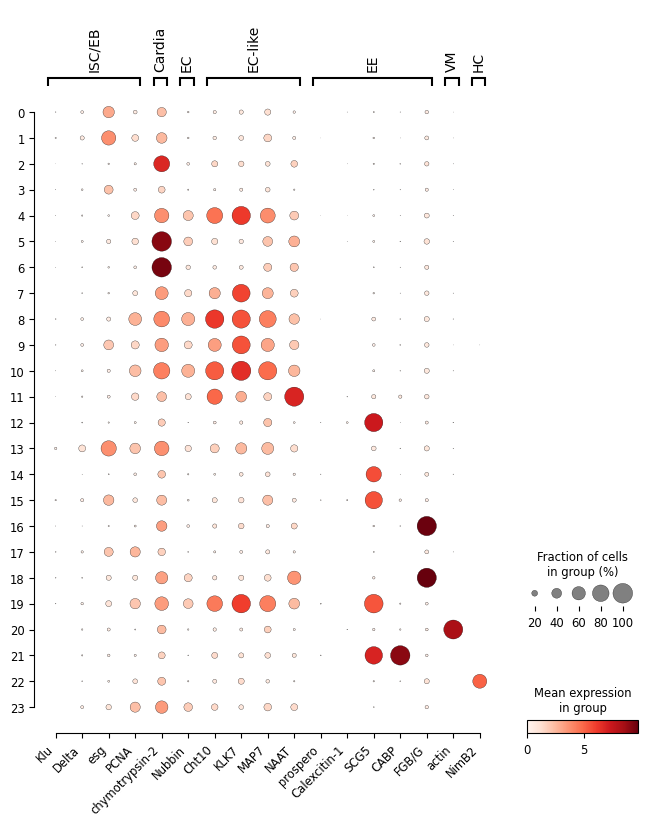

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sc.pl.dotplot(
    adata,
    var_names=marker_genes,
    # category_order=adata_plt.obs['order'],
    groupby='leiden_res',
    dendrogram=False,
    # log=True,
    # vmax=5,
    show=False,
)

axm = ax['mainplot_ax']

axm.set_xticklabels(
    [g_n[i.get_text()] for i in axm.get_xticklabels()],
    rotation=45, ha='right')
# axm.set_yticklabels(marker_genes.keys())

sns.despine(top=True, right=True, trim=1, ax=axm)

In [9]:
n_id = {
    'ISC/EB': ['0', '3', '17'],
    'ISC/EB-prol': ['1', '13', '23'],
    'Cardia-1': ['5', '6'],
    'Cardia-2': ['2'],
    'EC': ['4', '8', '10', '19'],
    'EC-like-1': ['9'],
    'EC-like-2': ['7'],
    'EC-like-3': ['11'],
    'EE-1': ['12', '14', '15'],
    'EE-2': ['21'],
    'EE-3': ['16', '18'],
    # 'EE-4': ['22'],
    'VM': ['20'],
    # 'FBC': ['27'],
    'HC': ['22'],
    # 'SV-2/UNC93': ['25'],
}

In [10]:
id_n = {}
for k, v in n_id.items():
    for i in v:
        id_n[i] = k

id_n

{'0': 'ISC/EB',
 '3': 'ISC/EB',
 '17': 'ISC/EB',
 '1': 'ISC/EB-prol',
 '13': 'ISC/EB-prol',
 '23': 'ISC/EB-prol',
 '5': 'Cardia-1',
 '6': 'Cardia-1',
 '2': 'Cardia-2',
 '4': 'EC',
 '8': 'EC',
 '10': 'EC',
 '19': 'EC',
 '9': 'EC-like-1',
 '7': 'EC-like-2',
 '11': 'EC-like-3',
 '12': 'EE-1',
 '14': 'EE-1',
 '15': 'EE-1',
 '21': 'EE-2',
 '16': 'EE-3',
 '18': 'EE-3',
 '20': 'VM',
 '22': 'HC'}

In [31]:
sorted([int(i) for i in id_n.keys()])

[0,
 1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23]

In [11]:
adata.obs['cluster'] = adata.obs['leiden_res'].map(
    lambda x: id_n[x] if x in id_n.keys() else x)

In [12]:
adata.obs['cluster_name'] = adata.obs['cluster']
adata.obs['cluster_name'] = adata.obs['cluster_name'].astype('category')
adata.obs['cluster_name'] = adata.obs[
        'cluster_name'
    ].cat.reorder_categories(list(n_id.keys()))

adata.obs['cluster_name'].unique()

['EC-like-2', 'EC', 'ISC/EB', 'EC-like-1', 'ISC/EB-prol', ..., 'EE-3', 'EE-2', 'Cardia-2', 'VM', 'HC']
Length: 13
Categories (13, object): ['ISC/EB', 'ISC/EB-prol', 'Cardia-1', 'Cardia-2', ..., 'EE-2', 'EE-3', 'VM', 'HC']

In [13]:
adata.write('./4.ann.h5ad')

In [13]:
dp = sc.pl.dotplot(
    adata,
    var_names=marker_genes,
    # category_order=adata_plt.obs['order'],
    groupby='cluster_name',
    dendrogram=False,
    # log=True,
    # vmax=5,
    show=False,
    return_fig=True,
)

dp.dot_color_df.to_csv('./4.dot_color_df.cxtri-cxtribl.csv')
dp.dot_size_df.to_csv('./4.dot_size_df.cxtri-cxtribl.csv')

In [15]:
adata.obs['batch'].unique()

['cxtri', 'cxtri-bl']
Categories (2, object): ['cxtri', 'cxtri-bl']

In [14]:
dp = sc.pl.dotplot(
    adata[adata.obs['batch'] == 'cxtri-bl'],
    var_names=marker_genes,
    # category_order=adata_plt.obs['order'],
    groupby='cluster_name',
    dendrogram=False,
    # log=True,
    # vmax=5,
    show=False,
    return_fig=True,
)

dp.dot_color_df.to_csv('./4.dot_color_df.cxtribl.csv')
dp.dot_size_df.to_csv('./4.dot_size_df.cxtribl.csv')

In [15]:
dp = sc.pl.dotplot(
    adata[adata.obs['batch'] == 'cxtri'],
    var_names=marker_genes,
    # category_order=adata_plt.obs['order'],
    groupby='cluster_name',
    dendrogram=False,
    # log=True,
    # vmax=5,
    show=False,
    return_fig=True,
)

dp.dot_color_df.to_csv('./4.dot_color_df.cxtri.csv')
dp.dot_size_df.to_csv('./4.dot_size_df.cxtri.csv')

In [16]:
g_n

{'Ctri08281': 'fibulin-1',
 'Ctri05145': 'Klu',
 'Ctri06068': 'Delta',
 'Ctri04136': 'esg',
 'Ctri03519': 'Nubbin',
 'Ctri09069': 'Cht10',
 'Ctri01811': 'NAAT',
 'Ctri01973': 'prospero',
 'Ctri02594': 'Calexcitin-1',
 'Ctri09277': 'actin',
 'Ctri04212': 'NimB2',
 'Ctri05970': 'PCNA',
 'Ctri06126': 'chymotrypsin-2',
 'Ctri04723': 'SCG5',
 'Ctri09956': 'KLK7',
 'Ctri05940': 'CABP',
 'Ctri07102': 'FGB/G',
 'Ctri09123': 'MAP7'}

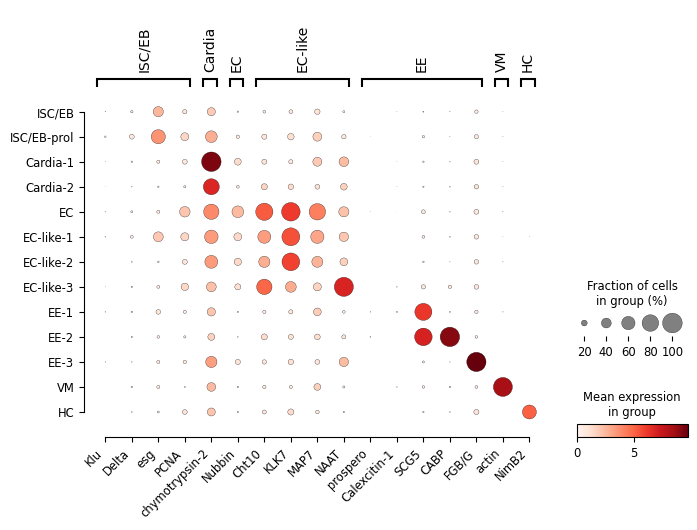

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

ax = sc.pl.dotplot(
    adata,
    var_names=marker_genes,
    # category_order=adata_plt.obs['order'],
    groupby='cluster_name',
    dendrogram=False,
    # log=True,
    # vmax=5,
    show=False,
)

axm = ax['mainplot_ax']

axm.set_xticklabels(
    [g_n[i.get_text()] for i in axm.get_xticklabels()],
    rotation=45, ha='right')
# axm.set_yticklabels(marker_genes.keys())

sns.despine(top=True, right=True, trim=1, ax=axm)

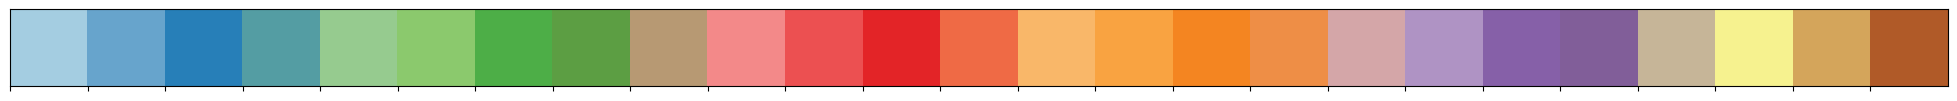

In [11]:
rc = ["#a4cde1","#67a4cc","#277fb8","#549da3","#96cb8f","#8bc96d","#4dae47","#5c9e43","#b79973","#f38989","#ec5051","#e32427","#ef6a45","#f9b769","#f9a341","#f48521","#ee8e46","#d4a6a8","#af93c4","#8660a8","#815e99","#c6b598","#f6f28f","#d4a55b","#b05a28"]

sns.palplot(rc)

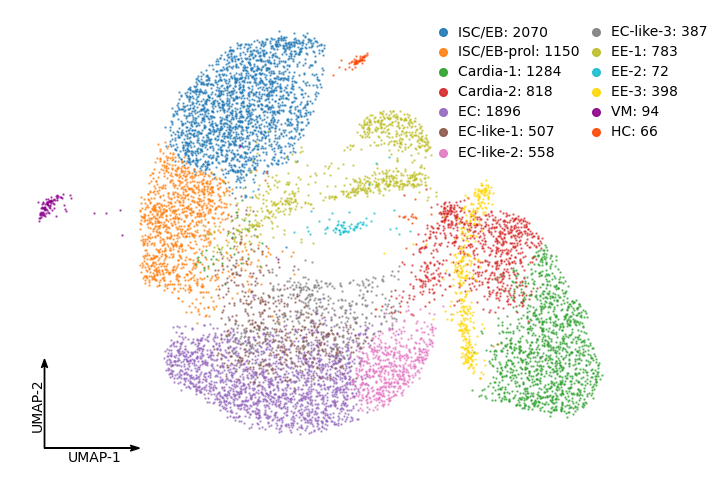

In [51]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns

# matplotlib.use('cairo')

fig, ax = plt.subplots(figsize=(8, 6))

# c = sns.color_palette('deep')
# set1 = sns.color_palette('Set1')
# set2 = sns.color_palette('Set2')
# def get_c(lst):
#     rc = ["#a4cde1","#67a4cc","#277fb8","#549da3","#96cb8f","#8bc96d","#4dae47","#5c9e43","#b79973","#f38989","#ec5051","#e32427","#ef6a45","#f9b769","#f9a341","#f48521","#ee8e46","#d4a6a8","#af93c4","#8660a8","#815e99","#c6b598","#f6f28f","#d4a55b","#b05a28"]
#     c = []
#     for i in lst:
#         c.append(rc[i])
#     return c.copy()
c = ["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD",
    "#8C564B", "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF",
    "#FFD700", "#8B008B", "#FF4500"]# "#00CED1", 'FBC',  "#d4a55b", 'SV-2/UNC93', 
cells = ['ISC/EB', 'ISC/EB-prol', 'Cardia-1', 'Cardia-2', 'EC', 'EC-like-1', 'EC-like-2', 'EC-like-3', 'EE-1', 'EE-2', 'EE-3', 'VM', 'HC']

umap = pd.DataFrame(
    adata.obsm['X_umap'], 
    columns=['umap1', 'umap2'],
    index=adata.obs.index
)

grp_color = {k:v for k, v in zip(cells, c)}

for lb in n_id.keys():
    pdf = umap[adata.obs['cluster_name'] == lb]
    l1, = ax.plot(
        pdf['umap1'], pdf['umap2'], '.', color=grp_color[lb],
        alpha=0.6, ms=1.5, clip_on = False)

x = 6; y = 1.5

ax.arrow(
    x-6.5, y-3, 0, 2.8, 
    width=0.01, head_width=0.2, overhang=0.3, 
    color='k', zorder=10)
ax.arrow(
    x-6.5, y-3, 2.8, 0, 
    width=0.01, head_width=0.2, overhang=0.3,
    color='k', zorder=10)

ax.set_axis_off()

ax.text(x-4.85, y-3.1, 'UMAP-1', ha='center', va='top')
ax.text(x-6.5, y-1.5, 'UMAP-2', ha='right', va='center', rotation=90)

x = 12.5; y = 13
for i, (cell, color) in enumerate(grp_color.items()):
    sep = 7
    j = i // sep

    ax.plot(x + j * 5, y - (i % sep) * 0.7, '.', color=color, mec=color, ms=11, alpha=0.9, clip_on = False)
    ax.text(x + j * 5 + 0.5, y - (i % sep) * 0.7, 
    f'{cell}: {len(adata.obs[adata.obs["cluster_name"] == cell])}', 
    ha='left', va='center', clip_on = False, fontsize=10)

# plt.savefig('./plots/f2.clust.umap_merge.png', dpi=600, bbox_inches='tight')
# plt.savefig('cxtribl_umap.pdf', bbox_inches='tight')
# plt.close()

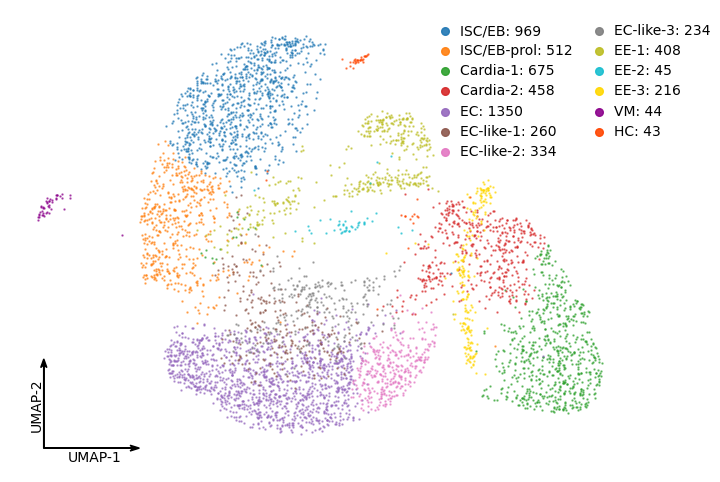

In [55]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns

# matplotlib.use('cairo')

fig, ax = plt.subplots(figsize=(8, 6))
tmp_adata = adata[adata.obs['batch'] == 'cxtri']
# c = sns.color_palette('deep')
# set1 = sns.color_palette('Set1')
# set2 = sns.color_palette('Set2')
# def get_c(lst):
#     rc = ["#a4cde1","#67a4cc","#277fb8","#549da3","#96cb8f","#8bc96d","#4dae47","#5c9e43","#b79973","#f38989","#ec5051","#e32427","#ef6a45","#f9b769","#f9a341","#f48521","#ee8e46","#d4a6a8","#af93c4","#8660a8","#815e99","#c6b598","#f6f28f","#d4a55b","#b05a28"]
#     c = []
#     for i in lst:
#         c.append(rc[i])
#     return c.copy()
c = ["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD",
    "#8C564B", "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF",
    "#FFD700", "#8B008B", "#FF4500"]# "#00CED1", 'FBC',  "#d4a55b", 'SV-2/UNC93', 
cells = ['ISC/EB', 'ISC/EB-prol', 'Cardia-1', 'Cardia-2', 'EC', 'EC-like-1', 'EC-like-2', 'EC-like-3', 'EE-1', 'EE-2', 'EE-3', 'VM', 'HC']

umap = pd.DataFrame(
    tmp_adata.obsm['X_umap'], 
    columns=['umap1', 'umap2'],
    index=tmp_adata.obs.index
)

grp_color = {k:v for k, v in zip(cells, c)}

for lb in n_id.keys():
    pdf = umap[tmp_adata.obs['cluster_name'] == lb]
    l1, = ax.plot(
        pdf['umap1'], pdf['umap2'], '.', color=grp_color[lb],
        alpha=0.6, ms=1.5, clip_on = False)

x = 6; y = 1.5

ax.arrow(
    x-6.5, y-3, 0, 2.8, 
    width=0.01, head_width=0.2, overhang=0.3, 
    color='k', zorder=10)
ax.arrow(
    x-6.5, y-3, 2.8, 0, 
    width=0.01, head_width=0.2, overhang=0.3,
    color='k', zorder=10)

ax.set_axis_off()

ax.text(x-4.85, y-3.1, 'UMAP-1', ha='center', va='top')
ax.text(x-6.5, y-1.5, 'UMAP-2', ha='right', va='center', rotation=90)

x = 12.5; y = 13
for i, (cell, color) in enumerate(grp_color.items()):
    sep = 7
    j = i // sep

    ax.plot(x + j * 5, y - (i % sep) * 0.7, '.', color=color, mec=color, ms=11, alpha=0.9, clip_on = False)
    ax.text(x + j * 5 + 0.5, y - (i % sep) * 0.7, 
    f'{cell}: {len(tmp_adata.obs[tmp_adata.obs["cluster_name"] == cell])}', 
    ha='left', va='center', clip_on = False, fontsize=10)

# plt.savefig('./plots/f2.clust.umap_merge.png', dpi=600, bbox_inches='tight')
# plt.savefig('cxtribl_umap.pdf', bbox_inches='tight')
# plt.close()

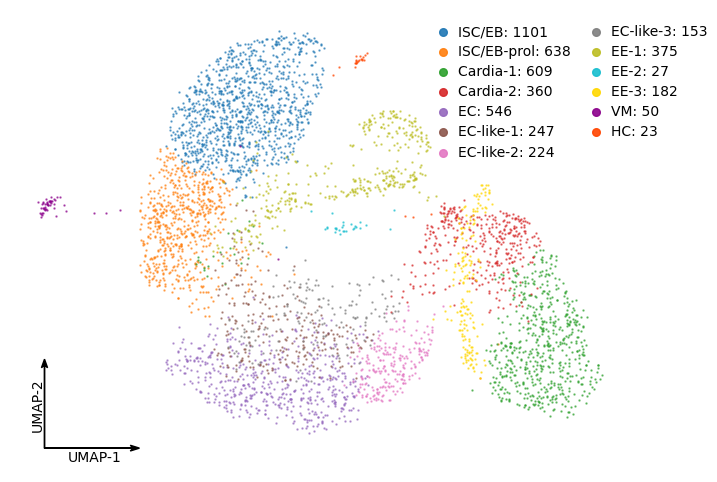

In [56]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns

# matplotlib.use('cairo')

fig, ax = plt.subplots(figsize=(8, 6))
tmp_adata = adata[adata.obs['batch'] == 'cxtri-bl']
# c = sns.color_palette('deep')
# set1 = sns.color_palette('Set1')
# set2 = sns.color_palette('Set2')
# def get_c(lst):
#     rc = ["#a4cde1","#67a4cc","#277fb8","#549da3","#96cb8f","#8bc96d","#4dae47","#5c9e43","#b79973","#f38989","#ec5051","#e32427","#ef6a45","#f9b769","#f9a341","#f48521","#ee8e46","#d4a6a8","#af93c4","#8660a8","#815e99","#c6b598","#f6f28f","#d4a55b","#b05a28"]
#     c = []
#     for i in lst:
#         c.append(rc[i])
#     return c.copy()
c = ["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD",
    "#8C564B", "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF",
    "#FFD700", "#8B008B", "#FF4500"]# "#00CED1", 'FBC',  "#d4a55b", 'SV-2/UNC93', 
cells = ['ISC/EB', 'ISC/EB-prol', 'Cardia-1', 'Cardia-2', 'EC', 'EC-like-1', 'EC-like-2', 'EC-like-3', 'EE-1', 'EE-2', 'EE-3', 'VM', 'HC']

umap = pd.DataFrame(
    tmp_adata.obsm['X_umap'], 
    columns=['umap1', 'umap2'],
    index=tmp_adata.obs.index
)

grp_color = {k:v for k, v in zip(cells, c)}

for lb in n_id.keys():
    pdf = umap[tmp_adata.obs['cluster_name'] == lb]
    l1, = ax.plot(
        pdf['umap1'], pdf['umap2'], '.', color=grp_color[lb],
        alpha=0.6, ms=1.5, clip_on = False)

x = 6; y = 1.5

ax.arrow(
    x-6.5, y-3, 0, 2.8, 
    width=0.01, head_width=0.2, overhang=0.3, 
    color='k', zorder=10)
ax.arrow(
    x-6.5, y-3, 2.8, 0, 
    width=0.01, head_width=0.2, overhang=0.3,
    color='k', zorder=10)

ax.set_axis_off()

ax.text(x-4.85, y-3.1, 'UMAP-1', ha='center', va='top')
ax.text(x-6.5, y-1.5, 'UMAP-2', ha='right', va='center', rotation=90)

x = 12.5; y = 13
for i, (cell, color) in enumerate(grp_color.items()):
    sep = 7
    j = i // sep

    ax.plot(x + j * 5, y - (i % sep) * 0.7, '.', color=color, mec=color, ms=11, alpha=0.9, clip_on = False)
    ax.text(x + j * 5 + 0.5, y - (i % sep) * 0.7, 
    f'{cell}: {len(tmp_adata.obs[tmp_adata.obs["cluster_name"] == cell])}', 
    ha='left', va='center', clip_on = False, fontsize=10)

# plt.savefig('./plots/f2.clust.umap_merge.png', dpi=600, bbox_inches='tight')
# plt.savefig('cxtribl_umap.pdf', bbox_inches='tight')
# plt.close()

In [16]:
adata.write('./4.ann.h5ad')

In [4]:
adata = sc.read('./4.ann.h5ad')
adata

AnnData object with n_obs × n_vars = 40350 × 4000
    obs: 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'mt_outlier', 'genes_outlier', 'batch', 'leiden_res', 'cluster', 'cluster_name'
    var: 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'batch_colors', 'hvg', 'leiden_res', 'leiden_res_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_pca_raw', 'X_umap'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
pdf = adata.obs[['batch', 'cluster_name']].value_counts().reset_index()

def sum_ct(df):
    df['sum'] = df['count'].sum()
    df['cellular percentage (%)'] = df['count'] / df['sum'] * 100
    df['cellular percentage (%)'] = df['cellular percentage (%)'].map(lambda x: round(x, 2))
    return df    

pdf = pdf.groupby(['batch']).apply(sum_ct)
pdf

/tmp/ipykernel_676/761387135.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  pdf = pdf.groupby(['batch']).apply(sum_ct)
/tmp/ipykernel_676/761387135.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  pdf = pdf.groupby(['batch']).apply(sum_ct)


batch cluster_name  count    sum  cellular percentage (%)
batch                                                                
aae    8      aae    EC-like-1   1686   9218                    18.29
       9      aae           EC   1654   9218                    17.94
       10     aae       ISC/EB   1566   9218                    16.99
       11     aae  ISC/EB-prol   1331   9218                    14.44
       14     aae     Cardia-2   1100   9218                    11.93
       16     aae    EC-like-2    722   9218                     7.83
       19     aae         EE-1    360   9218                     3.91
       24     aae         EE-3    228   9218                     2.47
       25     aae         EE-2    215   9218                     2.33
       26     aae     Cardia-1    171   9218                     1.86
       30     aae    EC-like-3    106   9218                     1.15
       37     aae         EE-4     34   9218                     0.37
       41     aae   SV-2/UNC93     15   9218                     0.16
       42     aae           HC     14   9218                     0.15
       43     aae           VM     10   9218                     0.11
       45     aae          FBC      6   9218                     0.07
aae-bl 2   aae-bl           EC   3221  10551                    30.53
       6   aae-bl    EC-like-1   2167  10551                    20.54
       7   aae-bl     Cardia-2   1844  10551                    17.48
       13  aae-bl       ISC/EB   1139  10551                    10.80
       15  aae-bl    EC-like-2    783  10551                     7.42
       17  aae-bl  ISC/EB-prol    559  10551                     5.30
       20  aae-bl         EE-1    260  10551                     2.46
       23  aae-bl     Cardia-1    236  10551                     2.24
       31  aae-bl    EC-like-3     96  10551                     0.91
       32  aae-bl         EE-2     90  10551                     0.85
       35  aae-bl         EE-3     75  10551                     0.71
       38  aae-bl           VM     32  10551                     0.30
       39  aae-bl         EE-4     30  10551                     0.28
       44  aae-bl           HC      9  10551                     0.09
       46  aae-bl   SV-2/UNC93      5  10551                     0.05
       47  aae-bl          FBC      5  10551                     0.05
aae-dv 0   aae-dv           EC   6502  20581                    31.59
       1   aae-dv       ISC/EB   3538  20581                    17.19
       3   aae-dv    EC-like-1   3060  20581                    14.87
       4   aae-dv     Cardia-2   2490  20581                    12.10
       5   aae-dv    EC-like-2   2238  20581                    10.87
       12  aae-dv  ISC/EB-prol   1218  20581                     5.92
       18  aae-dv           HC    367  20581                     1.78
       21  aae-dv           VM    260  20581                     1.26
       22  aae-dv     Cardia-1    240  20581                     1.17
       27  aae-dv   SV-2/UNC93    171  20581                     0.83
       28  aae-dv    EC-like-3    168  20581                     0.82
       29  aae-dv         EE-2    115  20581                     0.56
       33  aae-dv         EE-1     78  20581                     0.38
       34  aae-dv         EE-3     76  20581                     0.37
       36  aae-dv          FBC     35  20581                     0.17
       40  aae-dv         EE-4     25  20581                     0.12

In [5]:
pdf[(pdf['batch'] == 'cxtri-dv') & (pdf['cluster_name'] == 'a')].empty

True

In [10]:
def get_val(df, conditon, cell):
    cell_sum = int(df[(df['batch'] == conditon)]['sum'].iloc[0])
    tmp_df = df[(df['batch'] == conditon) & (df['cluster_name'] == cell)]
    if tmp_df.empty:
        return 0, cell_sum
    else:
        cell_num = int(tmp_df['count'].values)
        return cell_num, cell_sum - cell_num

df_fisher = deque()
for cell in pdf['cluster_name'].unique():
    v1c1, v1c0 = get_val(pdf, 'cxtri-dv', cell)
    v0c1, v0c0 = get_val(pdf, 'cxtri-bl', cell)
    table = [[v1c1, v1c0], [v0c1, v0c0]]
    odds_ratio, p_value = fisher_exact(table, alternative='two-sided')
    df_fisher.append([cell, 'cxtri-dv', 'cxtri-bl', odds_ratio, p_value])

df_fisher = pd.DataFrame(df_fisher, columns=['cell', 'condition1', 'condition2', 'odds_ratio', 'p_value'])
df_fisher

/tmp/ipykernel_28726/3161246067.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  cell_num = int(tmp_df['count'].values)


,cell,condition1,condition2,odds_ratio,p_value
0,EC-like-1,aae-dv,aae-bl,0.675702,7.211261e-36
1,EC,aae-dv,aae-bl,1.050965,5.589078e-02
2,ISC/EB,aae-dv,aae-bl,1.715418,9.708780e-53
3,ISC/EB-prol,aae-dv,aae-bl,1.124386,2.644183e-02
4,Cardia-2,aae-dv,aae-bl,0.649897,2.112647e-37
5,EC-like-2,aae-dv,aae-bl,1.522066,2.989336e-23
6,EE-1,aae-dv,aae-bl,0.150578,2.869618e-59
7,EE-3,aae-dv,aae-bl,0.517712,6.539096e-05
8,EE-2,aae-dv,aae-bl,0.653124,2.988550e-03
9,Cardia-1,aae-dv,aae-bl,0.515699,1.356577e-12


/tmp/ipykernel_31950/3263987851.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_31950/3263987851.py:33: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ratio = float(df_fisher[df_fisher['cell'] == cell]['odds_ratio'])
/tmp/ipykernel_31950/3263987851.py:34: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pval = float(df_fisher[df_fisher['cell'] == cell]['p_value'])


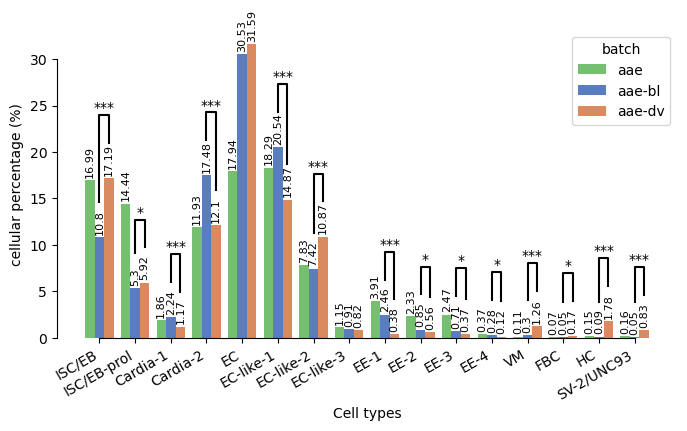

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

c = sns.color_palette('muted')

fig, ax = plt.subplots(figsize=(8, 4))

pdf['log2(cell number + 1)'] = pdf['count'].map(lambda x: np.log(x + 1) / np.log(2))

ax = sns.barplot(
    pdf,
    y='cellular percentage (%)',
    x='cluster_name',
    hue='batch',
    palette=[c[2], c[0], c[1]],
    ax=ax
)

ax.set_xlabel('Cell types')
ax.set_xticklabels(
    [t.get_text() for t in ax.get_xticklabels()], 
    rotation=30, ha='right', va='top'
)

for i in range(3):
    _ = ax.bar_label(ax.containers[i], fontsize=8, rotation=90, padding=2)

# plot sig
for i, cell in enumerate(ax.get_xticklabels()):
    cell = cell.get_text()
    if cell in list(df_fisher['cell']):
        ratio = float(df_fisher[df_fisher['cell'] == cell]['odds_ratio'])
        pval = float(df_fisher[df_fisher['cell'] == cell]['p_value'])
        if pval <= 0.05:
            start_bar = ax.patches[16 + i]
            end_bar = ax.patches[32 + i]
            # x
            start_x = start_bar.get_x() + start_bar.get_width() / 2
            end_x = end_bar.get_x() + end_bar.get_width() / 2
            # y
            bia = 3.8
            start_y = start_bar.get_y() + start_bar.get_height() + bia
            end_y = end_bar.get_y() + end_bar.get_height() + bia

            symbol = '***' if pval <= 1e-10 else '*'
            symbol_x = (start_x + end_x) / 2
            symbol_y = max(start_y, end_y) + 3
            ax.text(symbol_x, symbol_y, symbol, ha='center', va='bottom')

            # plot
            ax.plot(
                (start_x, start_x, end_x, end_x),
                (start_y, symbol_y, symbol_y, end_y),
                'k-'
            )

sns.despine(top=True, right=True, trim=3, ax=ax)

In [102]:
end_y

np.int64(0)

In [99]:
ax.patches[32].get_x()

np.float64(0.13333333333333328)

/tmp/user/1001/ipykernel_102816/3196642468.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


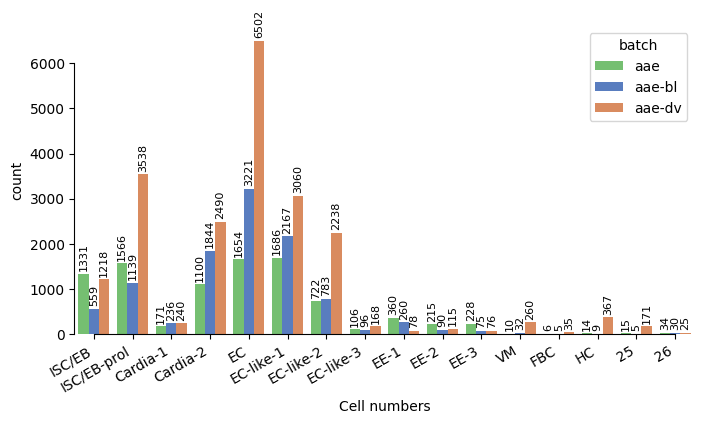

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

c = sns.color_palette('muted')

fig, ax = plt.subplots(figsize=(8, 4))

pdf['log2(cell number + 1)'] = pdf['count'].map(lambda x: np.log(x + 1) / np.log(2))

sns.barplot(
    pdf,
    y='count',
    x='cluster_name',
    hue='batch',
    palette=[c[2], c[0], c[1]],
    ax=ax
)

ax.set_xlabel('Cell numbers')
ax.set_xticklabels(
    [t.get_text() for t in ax.get_xticklabels()], 
    rotation=30, ha='right', va='top'
)

for i in range(3):
    _ = ax.bar_label(ax.containers[i], fontsize=8, rotation=90, padding=2)

sns.despine(top=True, right=True, trim=3, ax=ax)

# plot pdf

In [60]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

matplotlib.use('cairo')

ax = sc.pl.dotplot(
    adata,
    var_names=marker_genes,
    # category_order=adata_plt.obs['order'],
    groupby='cluster_name',
    dendrogram=False,
    # log=True,
    # vmax=5,
    show=False,
)

axm = ax['mainplot_ax']

axm.set_xticklabels(
    [g_n[i.get_text()] for i in axm.get_xticklabels()],
    rotation=45, ha='right')
# axm.set_yticklabels(marker_genes.keys())

sns.despine(top=True, right=True, trim=1, ax=axm)

plt.savefig('cxtribl_merge.dotplot.pdf', bbox_inches='tight')
plt.close()

In [57]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns

matplotlib.use('cairo')

fig, ax = plt.subplots(figsize=(8, 6))

# c = sns.color_palette('deep')
# set1 = sns.color_palette('Set1')
# set2 = sns.color_palette('Set2')
# def get_c(lst):
#     rc = ["#a4cde1","#67a4cc","#277fb8","#549da3","#96cb8f","#8bc96d","#4dae47","#5c9e43","#b79973","#f38989","#ec5051","#e32427","#ef6a45","#f9b769","#f9a341","#f48521","#ee8e46","#d4a6a8","#af93c4","#8660a8","#815e99","#c6b598","#f6f28f","#d4a55b","#b05a28"]
#     c = []
#     for i in lst:
#         c.append(rc[i])
#     return c.copy()
c = ["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD",
    "#8C564B", "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF",
    "#FFD700", "#8B008B", "#FF4500"]# "#00CED1", 'FBC',  "#d4a55b", 'SV-2/UNC93', 
cells = ['ISC/EB', 'ISC/EB-prol', 'Cardia-1', 'Cardia-2', 'EC', 'EC-like-1', 'EC-like-2', 'EC-like-3', 'EE-1', 'EE-2', 'EE-3', 'VM', 'HC']

umap = pd.DataFrame(
    adata.obsm['X_umap'], 
    columns=['umap1', 'umap2'],
    index=adata.obs.index
)

grp_color = {k:v for k, v in zip(cells, c)}

for lb in n_id.keys():
    pdf = umap[adata.obs['cluster_name'] == lb]
    l1, = ax.plot(
        pdf['umap1'], pdf['umap2'], '.', color=grp_color[lb],
        alpha=0.6, ms=1.5, clip_on = False)

x = 6; y = 1.5

ax.arrow(
    x-6.5, y-3, 0, 2.8, 
    width=0.01, head_width=0.2, overhang=0.3, 
    color='k', zorder=10)
ax.arrow(
    x-6.5, y-3, 2.8, 0, 
    width=0.01, head_width=0.2, overhang=0.3,
    color='k', zorder=10)

ax.set_axis_off()

ax.text(x-4.85, y-3.1, 'UMAP-1', ha='center', va='top')
ax.text(x-6.5, y-1.5, 'UMAP-2', ha='right', va='center', rotation=90)

x = 12.5; y = 13
for i, (cell, color) in enumerate(grp_color.items()):
    sep = 7
    j = i // sep

    ax.plot(x + j * 5, y - (i % sep) * 0.7, '.', color=color, mec=color, ms=11, alpha=0.9, clip_on = False)
    ax.text(x + j * 5 + 0.5, y - (i % sep) * 0.7, 
    f'{cell}: {len(adata.obs[adata.obs["cluster_name"] == cell])}', 
    ha='left', va='center', clip_on = False, fontsize=10)

# plt.savefig('./plots/f2.clust.umap_merge.png', dpi=600, bbox_inches='tight')
plt.savefig('cxtribl_merge.umap.pdf', bbox_inches='tight')
plt.close()

In [58]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns

matplotlib.use('cairo')

fig, ax = plt.subplots(figsize=(8, 6))
tmp_adata = adata[adata.obs['batch'] == 'cxtri']
# c = sns.color_palette('deep')
# set1 = sns.color_palette('Set1')
# set2 = sns.color_palette('Set2')
# def get_c(lst):
#     rc = ["#a4cde1","#67a4cc","#277fb8","#549da3","#96cb8f","#8bc96d","#4dae47","#5c9e43","#b79973","#f38989","#ec5051","#e32427","#ef6a45","#f9b769","#f9a341","#f48521","#ee8e46","#d4a6a8","#af93c4","#8660a8","#815e99","#c6b598","#f6f28f","#d4a55b","#b05a28"]
#     c = []
#     for i in lst:
#         c.append(rc[i])
#     return c.copy()
c = ["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD",
    "#8C564B", "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF",
    "#FFD700", "#8B008B", "#FF4500"]# "#00CED1", 'FBC',  "#d4a55b", 'SV-2/UNC93', 
cells = ['ISC/EB', 'ISC/EB-prol', 'Cardia-1', 'Cardia-2', 'EC', 'EC-like-1', 'EC-like-2', 'EC-like-3', 'EE-1', 'EE-2', 'EE-3', 'VM', 'HC']

umap = pd.DataFrame(
    tmp_adata.obsm['X_umap'], 
    columns=['umap1', 'umap2'],
    index=tmp_adata.obs.index
)

grp_color = {k:v for k, v in zip(cells, c)}

for lb in n_id.keys():
    pdf = umap[tmp_adata.obs['cluster_name'] == lb]
    l1, = ax.plot(
        pdf['umap1'], pdf['umap2'], '.', color=grp_color[lb],
        alpha=0.6, ms=1.5, clip_on = False)

x = 6; y = 1.5

ax.arrow(
    x-6.5, y-3, 0, 2.8, 
    width=0.01, head_width=0.2, overhang=0.3, 
    color='k', zorder=10)
ax.arrow(
    x-6.5, y-3, 2.8, 0, 
    width=0.01, head_width=0.2, overhang=0.3,
    color='k', zorder=10)

ax.set_axis_off()

ax.text(x-4.85, y-3.1, 'UMAP-1', ha='center', va='top')
ax.text(x-6.5, y-1.5, 'UMAP-2', ha='right', va='center', rotation=90)

x = 12.5; y = 13
for i, (cell, color) in enumerate(grp_color.items()):
    sep = 7
    j = i // sep

    ax.plot(x + j * 5, y - (i % sep) * 0.7, '.', color=color, mec=color, ms=11, alpha=0.9, clip_on = False)
    ax.text(x + j * 5 + 0.5, y - (i % sep) * 0.7, 
    f'{cell}: {len(tmp_adata.obs[tmp_adata.obs["cluster_name"] == cell])}', 
    ha='left', va='center', clip_on = False, fontsize=10)

# plt.savefig('./plots/f2.clust.umap_merge.png', dpi=600, bbox_inches='tight')
plt.savefig('cxtribl_merge.cxtri.umap.pdf', bbox_inches='tight')
plt.close()

In [59]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import seaborn as sns

matplotlib.use('cairo')

fig, ax = plt.subplots(figsize=(8, 6))
tmp_adata = adata[adata.obs['batch'] == 'cxtri-bl']
# c = sns.color_palette('deep')
# set1 = sns.color_palette('Set1')
# set2 = sns.color_palette('Set2')
# def get_c(lst):
#     rc = ["#a4cde1","#67a4cc","#277fb8","#549da3","#96cb8f","#8bc96d","#4dae47","#5c9e43","#b79973","#f38989","#ec5051","#e32427","#ef6a45","#f9b769","#f9a341","#f48521","#ee8e46","#d4a6a8","#af93c4","#8660a8","#815e99","#c6b598","#f6f28f","#d4a55b","#b05a28"]
#     c = []
#     for i in lst:
#         c.append(rc[i])
#     return c.copy()
c = ["#1F77B4", "#FF7F0E", "#2CA02C", "#D62728", "#9467BD",
    "#8C564B", "#E377C2", "#7F7F7F", "#BCBD22", "#17BECF",
    "#FFD700", "#8B008B", "#FF4500"]# "#00CED1", 'FBC',  "#d4a55b", 'SV-2/UNC93', 
cells = ['ISC/EB', 'ISC/EB-prol', 'Cardia-1', 'Cardia-2', 'EC', 'EC-like-1', 'EC-like-2', 'EC-like-3', 'EE-1', 'EE-2', 'EE-3', 'VM', 'HC']

umap = pd.DataFrame(
    tmp_adata.obsm['X_umap'], 
    columns=['umap1', 'umap2'],
    index=tmp_adata.obs.index
)

grp_color = {k:v for k, v in zip(cells, c)}

for lb in n_id.keys():
    pdf = umap[tmp_adata.obs['cluster_name'] == lb]
    l1, = ax.plot(
        pdf['umap1'], pdf['umap2'], '.', color=grp_color[lb],
        alpha=0.6, ms=1.5, clip_on = False)

x = 6; y = 1.5

ax.arrow(
    x-6.5, y-3, 0, 2.8, 
    width=0.01, head_width=0.2, overhang=0.3, 
    color='k', zorder=10)
ax.arrow(
    x-6.5, y-3, 2.8, 0, 
    width=0.01, head_width=0.2, overhang=0.3,
    color='k', zorder=10)

ax.set_axis_off()

ax.text(x-4.85, y-3.1, 'UMAP-1', ha='center', va='top')
ax.text(x-6.5, y-1.5, 'UMAP-2', ha='right', va='center', rotation=90)

x = 12.5; y = 13
for i, (cell, color) in enumerate(grp_color.items()):
    sep = 7
    j = i // sep

    ax.plot(x + j * 5, y - (i % sep) * 0.7, '.', color=color, mec=color, ms=11, alpha=0.9, clip_on = False)
    ax.text(x + j * 5 + 0.5, y - (i % sep) * 0.7, 
    f'{cell}: {len(tmp_adata.obs[tmp_adata.obs["cluster_name"] == cell])}', 
    ha='left', va='center', clip_on = False, fontsize=10)

# plt.savefig('./plots/f2.clust.umap_merge.png', dpi=600, bbox_inches='tight')
plt.savefig('cxtribl_merge.cxtribl.umap.pdf', bbox_inches='tight')
plt.close()

In [89]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

matplotlib.use('cairo')

c = sns.color_palette('muted')

fig, ax = plt.subplots(figsize=(8, 4))

pdf['log2(cell number + 1)'] = pdf['count'].map(lambda x: np.log(x + 1) / np.log(2))

ax = sns.barplot(
    pdf,
    y='cellular percentage (%)',
    x='cluster_name',
    hue='batch',
    palette=[c[2], c[0], c[1]],
    ax=ax
)

ax.set_xlabel('Cell types')
ax.set_xticklabels(
    [t.get_text() for t in ax.get_xticklabels()], 
    rotation=30, ha='right', va='top'
)

for i in range(3):
    _ = ax.bar_label(ax.containers[i], fontsize=8, rotation=90, padding=2)

# plot sig
for i, cell in enumerate(ax.get_xticklabels()):
    cell = cell.get_text()
    if cell in list(df_fisher['cell']):
        ratio = float(df_fisher[df_fisher['cell'] == cell]['odds_ratio'])
        pval = float(df_fisher[df_fisher['cell'] == cell]['p_value'])
        if pval <= 0.05:
            start_bar = ax.patches[16 + i]
            end_bar = ax.patches[32 + i]
            # x
            start_x = start_bar.get_x() + start_bar.get_width() / 2
            end_x = end_bar.get_x() + end_bar.get_width() / 2
            # y
            bia = 3.8
            start_y = start_bar.get_y() + start_bar.get_height() + bia
            end_y = end_bar.get_y() + end_bar.get_height() + bia

            symbol = '***' if pval <= 1e-10 else '*'
            symbol_x = (start_x + end_x) / 2
            symbol_y = max(start_y, end_y) + 3
            ax.text(symbol_x, symbol_y, symbol, ha='center', va='bottom')

            # plot
            ax.plot(
                (start_x, start_x, end_x, end_x),
                (start_y, symbol_y, symbol_y, end_y),
                'k-'
            )

sns.despine(top=True, right=True, trim=3, ax=ax)

plt.savefig('cxtridv_barplot.pdf', bbox_inches='tight')
plt.close()

/tmp/ipykernel_27893/2127285054.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(
/tmp/ipykernel_27893/2127285054.py:36: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  ratio = float(df_fisher[df_fisher['cell'] == cell]['odds_ratio'])
/tmp/ipykernel_27893/2127285054.py:37: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  pval = float(df_fisher[df_fisher['cell'] == cell]['p_value'])


In [2]:
adata = sc.read('./4.ann.h5ad')

adata = adata[adata.obs['batch'] == 'cxtri']
sc.tl.rank_genes_groups(
    adata, 
    "cluster_name", 
    method="wilcoxon", 
    pts=True, 
    key_added='rank_genes_groups.wilcoxon'
)

sc.tl.filter_rank_genes_groups(
    adata,
    key="rank_genes_groups.wilcoxon",
    key_added="rank_genes_groups.wilcoxon.filter",
)

name = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['names'])
padj = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['pvals_adj'])
lgFC = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['logfoldchanges'])
scores = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon']['scores'])
pts = adata.uns['rank_genes_groups.wilcoxon.filter']['pts']
pts_rest = adata.uns['rank_genes_groups.wilcoxon.filter']['pts_rest']

dfs = []
for cluster in name.columns:
    df = pd.concat(
        [
            name[cluster].dropna(), 
            padj[cluster].dropna(), 
            lgFC[cluster].dropna(),
            scores[cluster].dropna(),
        ], 
        axis=1
    )
    df.columns = ['names', 'pvals_adj', 'logfoldchanges', 'scores']
    df.set_index(['names'], inplace=True)

    pts_df = pd.concat([pts[[cluster]], pts_rest[[cluster]]], axis=1)
    pts_df.columns = ['pts', 'pts_rest']

    df = df.merge(pts_df, left_index=True, right_index=True, how='inner')
    df['leiden_res'] = cluster

    dfs.append(df)

markg = pd.concat(dfs, axis=0)
markg = markg.sort_values(['leiden_res', 'scores'], ascending=False)

markg.to_csv('./4.marker_genes.cxtri.csv')

/public21/home/sc90258/miniconda3/envs/hy-scanpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:669: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


In [3]:
adata = sc.read('./4.ann.h5ad')

adata = adata[adata.obs['batch'] == 'cxtri-bl']
sc.tl.rank_genes_groups(
    adata, 
    "cluster_name", 
    method="wilcoxon", 
    pts=True, 
    key_added='rank_genes_groups.wilcoxon'
)

sc.tl.filter_rank_genes_groups(
    adata,
    key="rank_genes_groups.wilcoxon",
    key_added="rank_genes_groups.wilcoxon.filter",
)

name = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['names'])
padj = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['pvals_adj'])
lgFC = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon.filter']['logfoldchanges'])
scores = pd.DataFrame(adata.uns['rank_genes_groups.wilcoxon']['scores'])
pts = adata.uns['rank_genes_groups.wilcoxon.filter']['pts']
pts_rest = adata.uns['rank_genes_groups.wilcoxon.filter']['pts_rest']

dfs = []
for cluster in name.columns:
    df = pd.concat(
        [
            name[cluster].dropna(), 
            padj[cluster].dropna(), 
            lgFC[cluster].dropna(),
            scores[cluster].dropna(),
        ], 
        axis=1
    )
    df.columns = ['names', 'pvals_adj', 'logfoldchanges', 'scores']
    df.set_index(['names'], inplace=True)

    pts_df = pd.concat([pts[[cluster]], pts_rest[[cluster]]], axis=1)
    pts_df.columns = ['pts', 'pts_rest']

    df = df.merge(pts_df, left_index=True, right_index=True, how='inner')
    df['leiden_res'] = cluster

    dfs.append(df)

markg = pd.concat(dfs, axis=0)
markg = markg.sort_values(['leiden_res', 'scores'], ascending=False)

markg.to_csv('./4.marker_genes.cxtribl.csv')

/public21/home/sc90258/miniconda3/envs/hy-scanpy/lib/python3.12/site-packages/scanpy/tools/_rank_genes_groups.py:669: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[key_added] = {}


In [2]:
adata = sc.read('./4.ann.h5ad')

# write umap plot data
umap = pd.DataFrame(
    adata.obsm['X_umap'], 
    columns=['umap1', 'umap2'],
    index=adata.obs.index
)

umap_lb = pd.concat([umap, adata.obs[['batch', 'cluster_name']]], axis=1)
umap_lb.index.name = 'barcode'

umap_lb.to_csv('4.umap_lb.cxtri-cxtribl.csv')